# Influence Simulation for Poisson Random Graph

We consider the following undirected graphs for simulating influence networks and cascades.

     erdos_renyi_graph - Poisson/Binomial Degree Distribution

In [1]:
from SimulationHelper import *
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt 
%matplotlib inline 

Hello this has loaded


In [2]:
## Multiprocessing Package - Speed up simulation
from multiprocessing import cpu_count
from dask.distributed import Client, progress
import dask
client = Client(threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:57638 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.04 GB


## Simulation of Influentials in a Poisson Random Graph

The following code is for simulating and measuring the cascade of influentials.

In [4]:
######################################################################
############################# Parameters #############################
######################################################################

N = 100
phi = 0.18
max_n_avg = 36
increment = 0.25
num_simulations = 50

n_avg = np.arange(1, max_n_avg, increment)
p = [avg/(N-1) for avg in n_avg]
n = len(p)

In [5]:
%%time
pool = []
x = []
for i in tqdm(range(num_simulations)):
    for j in range(n):
        pool.append(dask.delayed(run_simulation_RG_PC)(N, p[j], phi))

results = dask.compute(pool)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.73it/s]


KeyboardInterrupt: 

In [9]:
%%time

for phi in [0.05, 0.10, 0.2, 0.25, 0.5]:
    pool = []
    x = []
    for i in tqdm(range(num_simulations)):
        for j in range(n):
            pool.append(dask.delayed(run_simulation_RG_PC)(N, p[j], phi))

    results = dask.compute(pool)
    tmp = np.array(results[0])

    file_dir = "./Results"
    file_name = "RG_N_PC{}phi{}avg{}sim{}inc{}.npy".format(N,int(phi*100),max_n_avg,num_simulations, increment)
    file_path = os.path.join(file_dir, file_name)

    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    np.save(file_path, tmp)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.12it/s]


Wall time: 13min 19s


### Post Processing

This code reformats the simulation output for plotting.

In [14]:
tmp = np.array(results[0])
dims = (num_simulations, n)
names = ["0-5", "5-10", "10-15", "15-20", "0-10", "0-15", "0-20", "Normal", "95-100"]

s_05, s_10, s_15, s_20 =  np.reshape(tmp[:,0], dims),  np.reshape(tmp[:,1], dims),  np.reshape(tmp[:,2], dims),  np.reshape(tmp[:,3], dims)
s_010, s_015, s_020, s_n, s_95 = np.reshape(tmp[:,4], dims), np.reshape(tmp[:,5], dims),  np.reshape(tmp[:,6], dims),  np.reshape(tmp[:,7], dims),  np.reshape(tmp[:,8], dims)

t_05, t_10, t_15, t_20 = np.reshape(tmp[:,9], dims),  np.reshape(tmp[:,10], dims),  np.reshape(tmp[:,11], dims),  np.reshape(tmp[:,12], dims)
t_010, t_015, t_020, t_n, t_95 = np.reshape(tmp[:,13], dims), np.reshape(tmp[:,14], dims),  np.reshape(tmp[:,15], dims),  np.reshape(tmp[:,16], dims), np.reshape(tmp[:,17], dims)

In [15]:
# Number of Nodes of Network Influenced
S_05, S_10, S_15, S_20 =  np.apply_along_axis(np.mean, 0, s_05), np.apply_along_axis(np.mean, 0, s_10), np.apply_along_axis(np.mean, 0, s_15), np.apply_along_axis(np.mean, 0, s_20)
S_010, S_015, S_020, S_n, S_95 = np.apply_along_axis(np.mean, 0, s_010), np.apply_along_axis(np.mean, 0, s_015), np.apply_along_axis(np.mean, 0, s_020), np.apply_along_axis(np.mean, 0, s_n), np.apply_along_axis(np.mean, 0, s_95)

# Proportion of Network Influenced
N_05, N_10, N_15, N_20 =  [x/N for x in S_05], [x/N for x in S_10], [x/N for x in S_15], [x/N for x in S_20]
N_010, N_015, N_020, N_n, N_95 = [x/N for x in S_010], [x/N for x in S_015], [x/N for x in S_020], [x/N for x in S_n], [x/N for x in S_95]

# Averaged Time of Influenced Nodes
T_05, T_10, T_15, T_20 =  np.apply_along_axis(np.mean, 0, t_05), np.apply_along_axis(np.mean, 0, t_10), np.apply_along_axis(np.mean, 0, t_15), np.apply_along_axis(np.mean, 0, t_20)
T_010, T_015, T_020, T_n, T_95 = np.apply_along_axis(np.mean, 0, t_010), np.apply_along_axis(np.mean, 0, t_015), np.apply_along_axis(np.mean, 0, t_020), np.apply_along_axis(np.mean, 0, t_n), np.apply_along_axis(np.mean, 0, t_95)

### Plotting

The below plots represent 

- Comparison of (average) number of nodes influenced by influential/normal nodes as average degree changes
- Comparison of (average) percentage of nodes influenced by influential/normal nodes as average degree changes
- Comparison of (average) time of node influence by influential/normal nodes as average degree changes


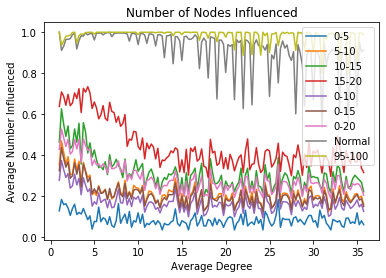

In [16]:
plt.plot(n_avg, N_05)
plt.plot(n_avg, N_10)
plt.plot(n_avg, N_15)
plt.plot(n_avg, N_20)
plt.plot(n_avg, N_010)
plt.plot(n_avg, N_015)
plt.plot(n_avg, N_020)
plt.plot(n_avg, N_n)
plt.plot(n_avg, N_95)
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Number of Nodes Influenced")
plt.legend(names)

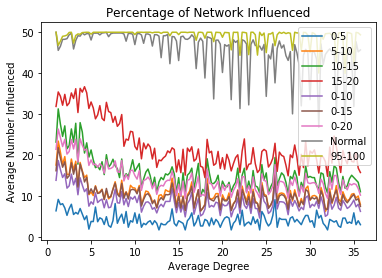

In [17]:
plt.plot(n_avg, S_05)
plt.plot(n_avg, S_10)
plt.plot(n_avg, S_15)
plt.plot(n_avg, S_20)
plt.plot(n_avg, S_010)
plt.plot(n_avg, S_015)
plt.plot(n_avg, S_020)
plt.plot(n_avg, S_n)
plt.plot(n_avg, S_95)
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Percentage of Network Influenced")
plt.legend(names)

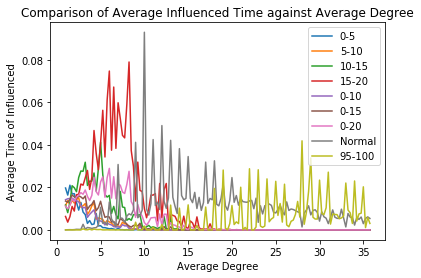

In [18]:
plt.plot(n_avg, T_05)
plt.plot(n_avg, T_10)
plt.plot(n_avg, T_15)
plt.plot(n_avg, T_20)
plt.plot(n_avg, T_010)
plt.plot(n_avg, T_015)
plt.plot(n_avg, T_020)
plt.plot(n_avg, T_n)
plt.plot(n_avg, T_95)
plt.ylabel("Average Time of Influenced")
plt.xlabel("Average Degree")
plt.title("Comparison of Average Influenced Time against Average Degree")
plt.legend(names)

### Storing Simulation Results

Raw simulation results are stored as npy files.

In [11]:
file_dir = "./Results"
file_name = "RG_N_PC{}phi{}avg{}sim{}inc{}.npy".format(N,int(phi*100),max_n_avg,num_simulations, increment)
file_path = os.path.join(file_dir, file_name)

if not os.path.exists(file_dir):
    os.makedirs(file_dir)
np.save(file_path, tmp)

In [12]:
np.load(file_path)

array([[5.00000000e+01, 5.00000000e+01, 5.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+01, 5.00000000e+01, 5.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.33333333e+00, 1.10000000e+01, 1.56666667e+01, ...,
        1.66666667e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.66666667e+00, 4.50000000e+00, 6.66666667e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.66666667e+00, 4.50000000e+00, 6.66666667e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.66666667e+00, 4.50000000e+00, 3.53333333e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])